In [91]:
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch import optim

from utils import utils

In [92]:
source_idx = 1
target_idx = 2
winter_idx = 0
summer_idx = 1

In [109]:
class NIOM:
    def __init__(self, X):
        X = X[(X.Time > 1)&(X.Time < 8)].Energy.rolling(15).mean()
        self.p_ave = X.max()
        print(self.p_ave)
    def predict(self, X):
        X = X.Energy.rolling(15).mean()
        return X > self.p_ave

In [110]:
target_X_all = pd.read_csv(f"./deep_occupancy_detection/data/{target_idx}_X_train_niom.csv")
target_X = target_X_all[(target_X_all.Time >= 12)&(target_X_all.Time < 44)]
target_X = target_X.reset_index(drop=True)

target_y_task = pd.read_csv(f"./deep_occupancy_detection/data/{target_idx}_Y_train_niom.csv")[target_X.Season==summer_idx]
target_X = target_X[target_X.Season==summer_idx]

In [111]:
niom = NIOM(target_X_all)
pred_y = niom.predict(target_X)

259164.96986666665


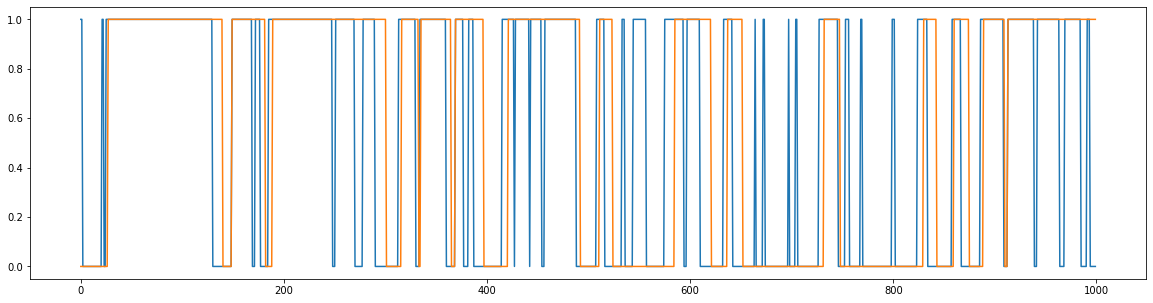

In [117]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 5))
plt.plot(target_y_task.Occupancy[:1000])
plt.plot(pred_y[:1000])